In [1]:
import os
import sys

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from tqdm.notebook import tqdm
%matplotlib inline

In [4]:
import barcodes

In [5]:
import pickle
from cka import cka
from msid import msid_score
from svcca import svcca

def msid_score_n(a, b, n):
    total = 0.0
    for _ in range(n):
        total += msid_score(a, b)
    return total / n

### Exp many clusters

In [6]:
np.random.seed(7)

all_clusters = []

for i in range(60):
    all_clusters.append(np.random.multivariate_normal(np.zeros(2), np.eye(2), 5))
    
A_base = np.concatenate(all_clusters)

In [7]:
def split2clusters(k):
    
    if k == 1:
        return A_base
    
    arr = []
    
    for i in range(60):
        idx = i % k
    
        theta = 2 * np.pi * idx / k
        d = np.array([np.cos(theta), np.sin(theta)]) * 10
        
        arr.append(all_clusters[i] + d)
        
    A_mod = np.concatenate(arr)
    
    return A_mod

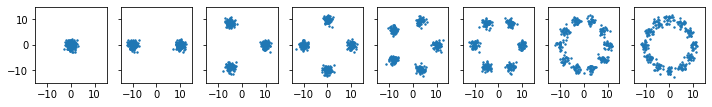

In [8]:
ALL = [2, 3, 4, 5, 6, 10, 12]

fig, ax = plt.subplots(1, len(ALL) + 1)
fig.set_size_inches(12, 1.4)

for idx, k in enumerate([0] + ALL):
    
    if idx == 0:
        A = A_base
    else:
        A = split2clusters(k)

    ax[idx].scatter(x = A[:,0], y = A[:,1], s = 2)
    ax[idx].set_xlim(-15, 15)
    ax[idx].set_ylim(-15, 15)
    
for ax in fig.get_axes():
    ax.label_outer()

In [12]:
%%time
res1 = []
res2 = []
res_cka = []
res_imd = []
res_svcca = []

barcs1 = []
barcs2 = []

for i, k in enumerate(ALL):
    
    A_mod = split2clusters(k)
    
    #barc = barcodes.calc_embed_dist(A_base, A_mod, norm = 'quantile')
    #barcodes.plot_barcodes(barcodes.barc2array(barc), title = '')
    #plt.show()
    res1.append(barcodes.h1sum(barc))
    barcs1.append(barc)

    #barc = barcodes.calc_embed_dist(A_mod, A_base, norm = 'quantile')
    #barcodes.plot_barcodes(barcodes.barc2array(barc), title = '')
    #plt.show()
    res2.append(barcodes.h1sum(barc))
    barcs2.append(barc)
    
    res_cka.append(cka(A_base, A_mod))
    res_imd.append(msid_score_n(A_base, A_mod, 100))    
    res_svcca.append(svcca(A_base.T, A_mod.T))
    break

CPU times: user 19.5 s, sys: 802 ms, total: 20.3 s
Wall time: 12.1 s


In [38]:
#pickle.dump((res1, res2, res_cka), open('exp_clusters.pickle', 'wb'))
(res1, res2, res_cka) = pickle.load(open('exp_clusters.pickle', 'rb'))

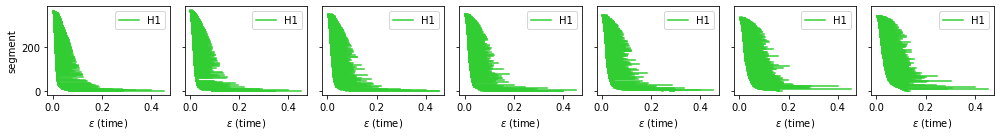

In [105]:
clusters2show = ALL
cols = len(clusters2show)

fig, ax = plt.subplots(1, cols, sharey = True)
fig.set_size_inches((2 * cols, 2))

for col, k in enumerate(clusters2show):
    i = ALL.index(k)
    barc = barcs1[i]
    #ax[col].set_ylim(0, 300)
    #ax[col].set_xlim(0, 0.75)
    barcodes.plot_barcodes(barcodes.barc2array(barc), title = '', ax = ax[col], fig = fig)
    
    if col > 0:
        ax[col].set_ylabel('')
        
    ax[col].legend(loc = 'best')
    
fig.tight_layout()
plt.show()

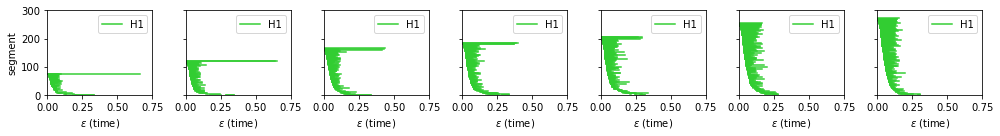

In [104]:
clusters2show = ALL
cols = len(clusters2show)

fig, ax = plt.subplots(1, cols, sharey = True)
fig.set_size_inches((2 * cols, 2))

for col, k in enumerate(clusters2show):
    i = ALL.index(k)
    barc = barcs2[i]
    ax[col].set_ylim(0, 300)
    ax[col].set_xlim(0, 0.75)
    barcodes.plot_barcodes(barcodes.barc2array(barc), title = '', ax = ax[col], fig = fig)
    
    if col > 0:
        ax[col].set_ylabel('')
        
    ax[col].legend(loc = 'best')
    
fig.tight_layout()
plt.show()

In [ ]:
clusters2show = [2, 6, 12]
cols = len(clusters2show)

fig, ax = plt.subplots(1, cols, sharey = True)
fig.set_size_inches((2 * cols, 2))

for col, k in enumerate(clusters2show):
    i = ALL.index(k)
    barc = barcs2[i]
    ax[col].set_ylim(0, 300)
    ax[col].set_xlim(0, 0.75)
    barcodes.plot_barcodes(barcodes.barc2array(barc), title = '', ax = ax[col], fig = fig)
    
    if col > 0:
        ax[col].set_ylabel('')
        
    ax[col].legend(loc = 'best')
    
fig.tight_layout()
plt.show()

In [34]:
res_total = 0.5 * (np.array(res1) + np.array(res2))

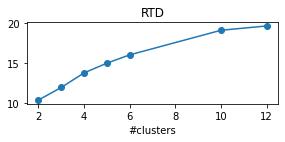

In [17]:
clusters_list = [2, 3, 4, 5, 6, 10, 12]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((4.5, 1.5))
plt.plot(clusters_list, res_total[:len(clusters_list)], 'o-', label = 'base/mod')
ax.set_xlabel('#clusters')
plt.title('RTD')
plt.show()

In [18]:
stats.kendalltau(res_total, clusters_list).correlation

1.0

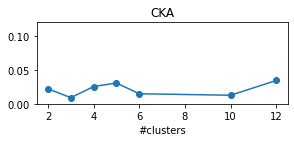

In [32]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches((4.5, 1.5))
ax.set_xlabel('#clusters')
ax.set_ylim(0.0, 0.12)
plt.title('CKA')
plt.plot(clusters_list, res_cka[:len(clusters_list)], 'o-')
plt.show()

In [33]:
stats.kendalltau(res_cka, clusters_list).correlation

0.23809523809523814

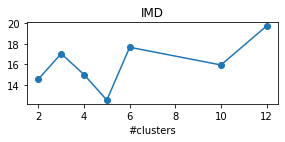

In [21]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches((4.5, 1.5))
ax.set_xlabel('#clusters')
plt.title('IMD')
plt.plot(clusters_list, res_imd[:len(clusters_list)], 'o-')
plt.show()

In [22]:
stats.kendalltau(res_imd, clusters_list).correlation

0.4285714285714286

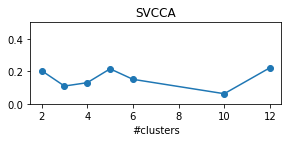

In [26]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches((4.5, 1.5))
ax.set_ylim(0.0, 0.5)
ax.set_xlabel('#clusters')
plt.title('SVCCA')
plt.plot(clusters_list, res_svcca[:len(clusters_list)], 'o-')
plt.show()

In [24]:
stats.kendalltau(res_svcca, clusters_list).correlation

0.14285714285714288